<a href="https://colab.research.google.com/github/followviny/ML_kaggle/blob/main/1_diamonds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[<font size=6>💎Diamonds</font>](https://www.kaggle.com/t/83ded147b1ef4e69b7b273ed313f6746)**.

In [ ]:
df = pd.read_csv('XY_diamonds.csv'); df

,carat,depth,table,x,y,z,cut,color,clarity,price
0,0.35,67.2,57.1,4.64,4.69,2.87,I,G,VS1,NaN
1,1.64,67.3,60.7,7.84,7.82,4.94,V,E,SI1,NaN
...,...,...,...,...,...,...,...,...,...,...
199998,0.48,68.7,53.0,4.47,4.45,2.72,I,G,IF,1474.0
199999,0.48,65.0,64.7,5.60,5.62,3.44,I,H,VS2,765.0


In [ ]:
df.price.info()

<class 'pandas.core.series.Series'>
RangeIndex: 200000 entries, 0 to 199999
Series name: price
Non-Null Count   Dtype  
--------------   -----  
160000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
vX = df.query('price!=price').drop('price', axis=1)  # slice a test sample
tXY = df.query('price==price')                       # slice training sample
tX, tY = tXY.drop('price', axis=1), tXY.price        # split into training I/O

In [ ]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

# ScatterCorrHist(tXY.head(200))  # takes a minute time to run

In [ ]:
print(tX.describe())
print(tY.describe())

           carat      depth      table          x          y          z
count  160000.00  160000.00  160000.00  160000.00  160000.00  160000.00
mean        0.80      67.86      57.45       5.73       5.74       3.54
...          ...        ...        ...        ...        ...        ...
75%         1.07      69.80      63.10       6.63       6.62       4.09
max         5.76      86.60      96.10      11.79      65.41       8.95

[8 rows x 6 columns]
count    160000.00
mean       4487.57
           ...    
75%        6160.25
max       23566.00
Name: price, Length: 8, dtype: float64


<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Matrix of Numeric Features and Target (Price)')

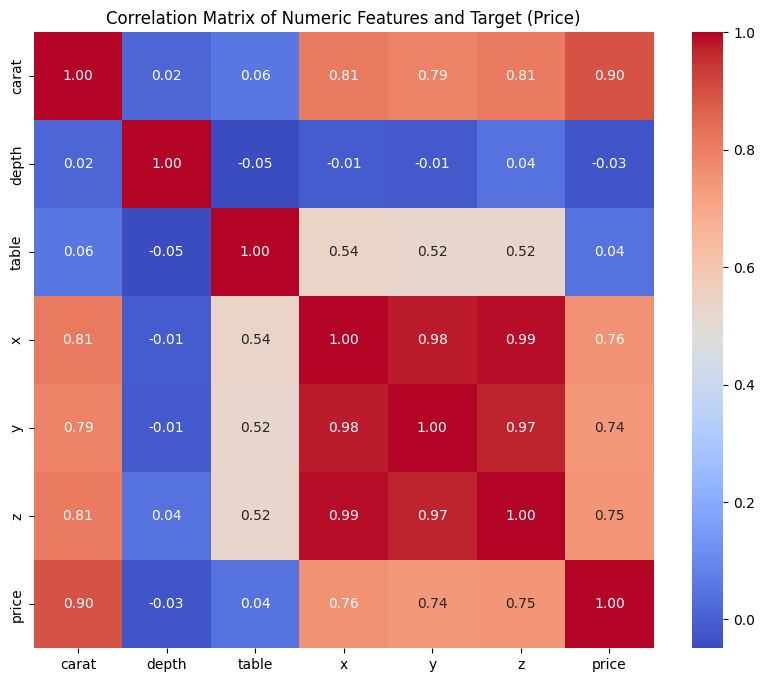

In [ ]:
numeric_cols = tX.select_dtypes(include=[np.number]).columns
combined_data = pd.concat([tX[numeric_cols], tY], axis=1)

correlation_matrix = combined_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features and Target (Price)')
plt.show()


<Axes: xlabel='price', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Diamond Prices')

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Frequency')

<Axes: xlabel='volume', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Diamond Volume')

Text(0.5, 0, 'Volume')

Text(0, 0.5, 'Frequency')

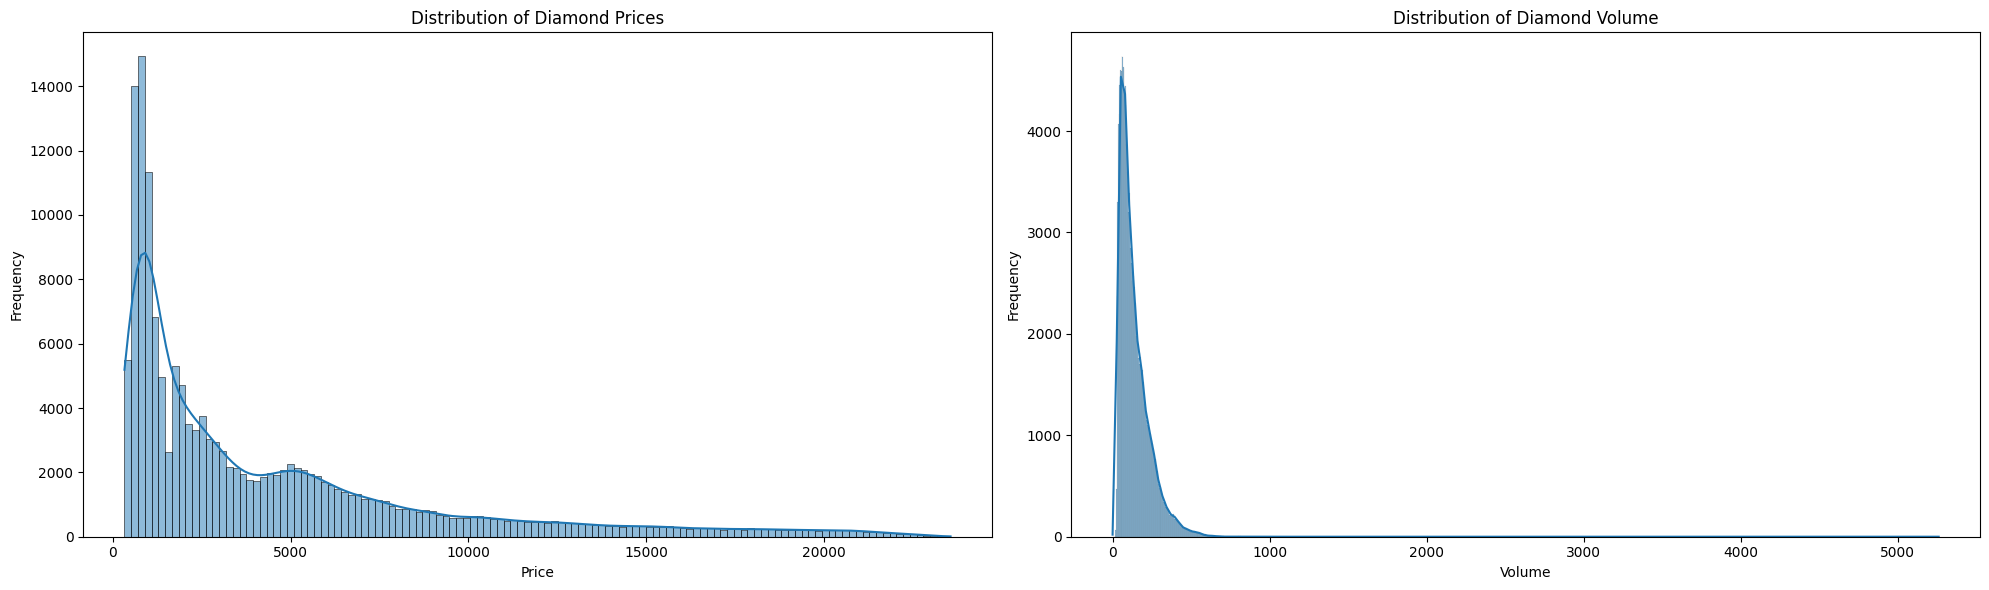

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tX['volume'] = tX['x'] * tX['y'] * tX['z']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

sns.histplot(tY, kde=True, ax=ax1)
ax1.set_title('Distribution of Diamond Prices')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

sns.histplot(tX['volume'], kde=True, ax=ax2)
ax2.set_title('Distribution of Diamond Volume')
ax2.set_xlabel('Volume')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

<Axes: >

<Axes: xlabel='log_carat', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of log_carat')

<Axes: >

<Axes: xlabel='log_volume', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of log_volume')

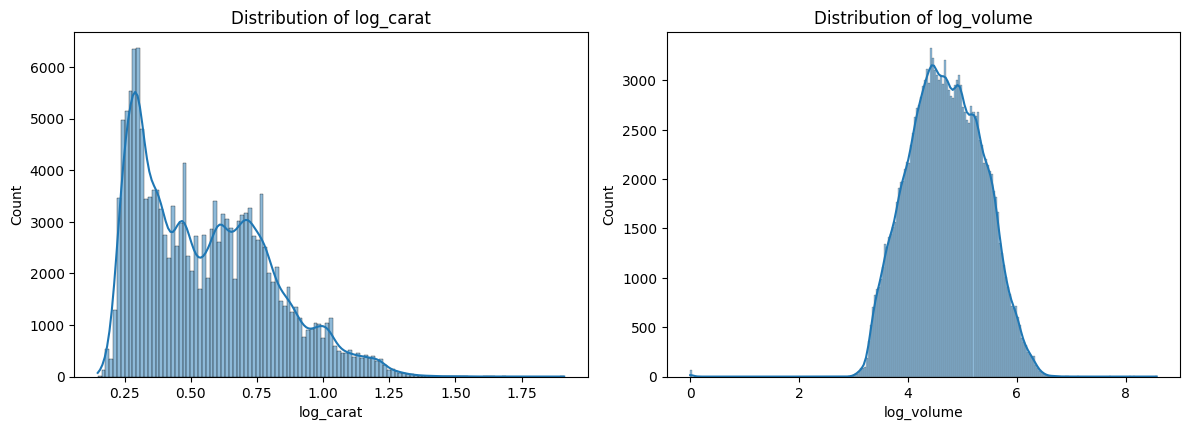

In [ ]:
tX['log_carat'] = np.log1p(tX['carat'])
tX['log_volume'] = np.log1p(tX['volume'])

numeric_features = [ 'log_carat', 'log_volume']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(tX[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer, OneHotEncoder, RobustScaler
from scipy.stats.mstats import winsorize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

def cap_outliers(df, column):
    percentile_99 = df[column].quantile(0.99)
    df[column] = np.where(df[column] > percentile_99, percentile_99, df[column])
    return df

tX['volume'] = tX['x'] * tX['y'] * tX['z']


tX = cap_outliers(tX, 'carat')
tX = cap_outliers(tX, 'volume')
tX['log_carat'] = np.log1p(tX['carat'])
tX['log_volume'] = np.log1p(tX['volume'])
tX['volume_winsorized'] = winsorize(tX['volume'], limits=[0, 0.01])
tX['carat_bin'] = pd.qcut(tX['carat'], q=10, labels=False, duplicates='drop')

log_tY = np.log1p(tY)

X_train, X_val, y_train, y_val = train_test_split(tX, log_tY, test_size=0.2, random_state=42)


numeric_features = ['carat', 'depth', 'table', 'volume', 'log_carat', 'log_volume', 'volume_winsorized']
categorical_features = ['cut', 'color', 'clarity', 'carat_bin']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=3, include_bias=False), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [ ]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['carat', 'depth', 'table',
                                                   'volume', 'log_carat',
                                                   'log_volume',
                                                   'volume_winsorized']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['cut', 'color', 'clarity',
                                                   'carat_bin'])])),
                ('regressor', Ridge())])

<font color=green><h3><b>$\gamma$. Generate and post-process predictions.</font>

In [ ]:
y_pred = np.expm1(model.predict(X_val))


mae = mean_absolute_error(np.expm1(y_val), y_pred)
print(f"Mean Absolute Error: {mae:.2f}")

vX['volume'] = vX['x'] * vX['y'] * vX['z']

vX = cap_outliers(vX, 'carat')
vX = cap_outliers(vX, 'volume')

vX['log_carat'] = np.log1p(vX['carat'])
vX['log_volume'] = np.log1p(vX['volume'])
vX['volume_winsorized'] = winsorize(vX['volume'], limits=[0, 0.01])
vX['carat_bin'] = pd.qcut(vX['carat'], q=10, labels=False, duplicates='drop')


pY = np.expm1(model.predict(vX))
pY = np.maximum(pY, 10)

submission = pd.DataFrame({
    'price': pY
}, index=range(1, len(vX) + 1))

submission.index.name = 'id'

#ToCSV(submission, '💎Yteam🐍')
print(submission.head())

Mean Absolute Error: 641.40
       price
id          
1     818.86
2   14374.59
..       ...
4     614.86
5     911.16

[5 rows x 1 columns]


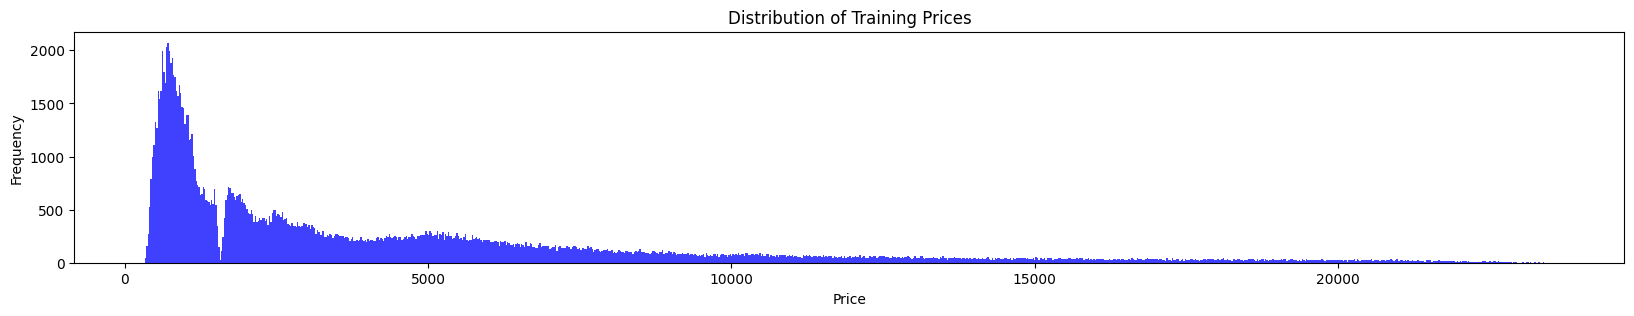

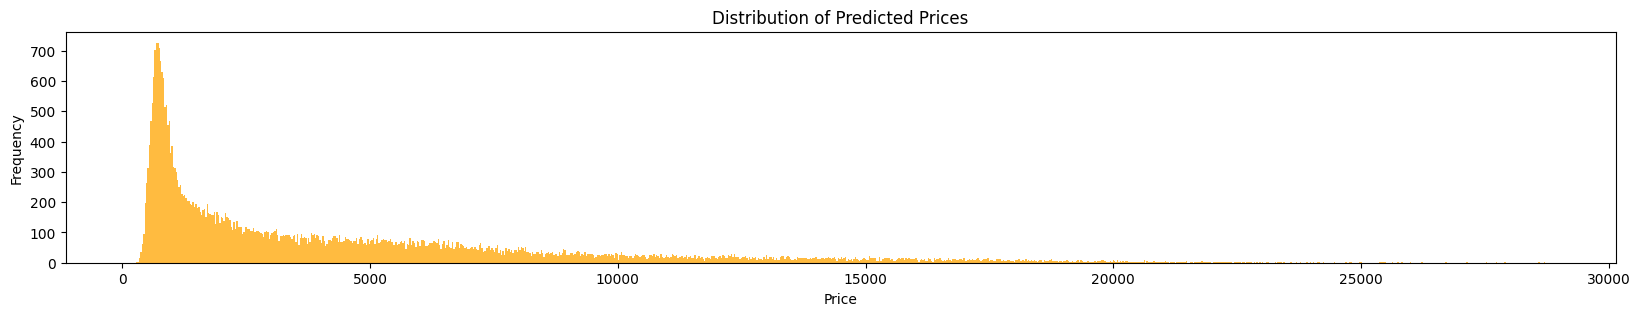

In [ ]:
import matplotlib.pyplot as plt

def plot_price_distributions(tY, pY):
    plt.figure(figsize=(20, 3))
    plt.hist(tY, bins=1000, alpha=0.75, color='blue')
    plt.title("Distribution of Training Prices")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.hist(pY, bins=1000, alpha=0.75, color='orange')
    plt.title("Distribution of Predicted Prices")
    plt.xlabel("Price")
    plt.ylabel("Frequency")
    plt.show()

plot_price_distributions(tY, pY)


<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Elements of preprocessing pipeline.</font>


1. Feature Engineering

   *   Volume calculation: Since the volume of a diamond conveys more information about its size than its individual dimensions do, we computed the volume of diamonds using their dimensions. The correlation matrix indicated that volume is positively correlated with the price, justifying its inclusion in the model. This showed better results, then individual x,y,z.
   *   Log Transformations: I used volume and carat log transformations to make skewness less and improve distribution normalcy. It is helpful, because  normally distributed data improves the performance.
   *    Winsorization: Used to limit extreme values that might be outliers without removing them entirely. This helps to prevent the model from being influenced by extreme values. To keep most of the data while minimizing extreme effects, I went with the 99th percentile.
   *     Bining of Carat: Non-linear relationships between carat size and price can be captured by binning into quantiles, which is advantageous for models that may not naturally comprehend these relationships.
   *     Applied polynomial feature of degree 3 to numeric features. Showed better results than degree 2, Ridge regression model (with L2 regularization) was chosen to decrease risk of model being too complex.
   *    Applied One-Hot Encoding to categorical features. It's a standard method for handling categorical variables in regression models. It converts categorical variables into a binary matrix, which the linear regression model can then process.

2. Effectiveness Evaluation

   *   The effectiveness of these preprocessing steps is evaluated through the Mean Absolute Error (MAE) on the validation set. Additionally, correlation analysis, distribution plots, and model performance metrics were used to assess how well these steps are working.
   *    Moreover, before and after transformations I checked distributions, which made it possible to determine whether the log transformations and winsorization successfully normalized the data.   

3. Other Attempts

   *    Tried normalization but found log transformations more effective.
   *     Different degrees of polynomial features, different binning strategies, and transformations, PCA. But it all didn't make mae lower.














  

<font color=green><h4><b>Task 2. Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach.

1. Modeling Approach

    *  Ridge Regression: I choose ridge regression because it can handle multicollinearity well and has regularization features that assist reduce overfitting, which is important considering the complexity of the polynomial features.
    *  Pipeline Integration: The danger of data leakage is reduced by using a preprocessing and modeling pipeline, which ensures that transformations are applied consistently to training and test datasets.
    *  Included polynomial features (up to degree 3) to capture potential nonlinear relationships between features and the target variable (price). This decision was because of hypothesis that interactions between certain numerical features (such as volume and carat) could have non-linear effects on diamond price.

2. Evaluating Effectiveness

    *   A low mean absolute error on the validation data indicates that the model is generalizing well, according to monitoring the MAE on both the training and validation datasets.
    *   By tuning the alpha parameter of Ridge regression, I was able to control overfitting. A regularization alpha=1.0 was selected to maintain a balance between bias and variance, reducing overfitting caused by the polynomial feature expansion.

3. Other Attempts

    *   Explored linear and Lasso regression but Ridge performed better.
    *  Higher-degree polynomial features (degree 4 or more) increased overfitting and led to worse generalization, even with regularization.

<font color=green><h3><b>$\zeta$. References</b></h3></font>

1. [ISLP (2017). Introduction to Statistical Learning with Applications in Python](https://www.statlearning.com/)
2. [Statistics By Jim (How to handle multicollinearity in regression analysis?)](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)
3. [Stack Exchange (What metrics should I use to evaluate the performance of my regression model?)](https://datascience.stackexchange.com/questions/123667/best-metrics-to-evaluate-the-performance-of-a-regression-model)
4. [DeepChecks (What are some techniques to improve the performance of a machine learning model?)](https://deepchecks.com/how-to-improve-the-performance-of-your-ml-model/)
5. [API Reference](https://scikit-learn.org/stable/api/index.html)
